In [24]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import growth_simulations as g
import seaborn as sns
import time
from matplotlib import rc
rc('text', usetex=False)
# font = {'weight' : 'bold',
#         'size'   : 22}	
# plt.rc('font', **font)
import seaborn as sns
from sklearn.neighbors import KernelDensity
# from sklearn.grid_search import GridSearchCV
import scipy.integrate as integrate

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
l = np.array([1.0])
td_std = np.array([0.0])
l_std = np.array([0.2])
delta = np.array([1.0])
# beta = np.linspace(0.05, 0.5, num=10) # 9
beta = np.array([0.3])
r = beta/(1-beta)
alpha = np.array([1.0]) # 5
tic=time.clock()
num_rep = 1
X = [len(beta), len(alpha), num_rep]
num_celltypes = 3  #mother, daughter, full_pop
a_shape = X+[2]  # zero for simulations, one for numerical estimation based on E-L equation.
print a_shape
celltype = ['Mother', 'Daughter', 'Population']
params = {'nstep': 1200, 'dt': 0.01, 'v_init': 1.0, 'modeltype': 7, 'delta': delta[0], 'lambda': l[0],
            'td_std': td_std[0], 'lambda_std': l_std[0]}


[1, 1, 1, 2]


In [38]:
output_val = np.zeros(a_shape)
temp3=1
bw = 0.001
L=np.linspace(0.97,1.0,61)
for i0 in range(temp3):
    inds=np.unravel_index(i0,X)
    # setting the parameters
    params['r']=beta[inds[0]] / (1 - beta[inds[0]])
    params['alpha']=alpha[inds[1]]
    # doing the simulation
    init_pop = g.starting_popn(params)

    params['nstep'] = 500  # seeding the population with a simulated one
    c, obs, [temp_vols, temp_vols_G1] = g.discr_time_1(params, init_pop)
    init_pop = g.starting_popn_seeded(c, params)
    params['nstep'] = 900  # now we run this simulation for longer with a better seeded population.
    c, obs, [temp_vols, temp_vols_G1] = g.discr_time_1(params, init_pop)

    # calculating the simulation population growth rate and storing it
    temp = scipy.stats.linregress(obs[1][400:], np.log(obs[12][400:]))
    output_val[inds[0],inds[1],inds[2],0]=temp[0]
    # calculating the kernel density estimation
    kde1= KernelDensity(bandwidth=bw,kernel='gaussian')
    kde2= KernelDensity(bandwidth=bw,kernel='gaussian')
    t1=np.array([obj.t_grow for obj in c[10**4:] if obj.celltype==0 and obj.tb>400* params['dt'] * np.log(2)/params['lambda']]).reshape(-1,1)
    t2=np.array([obj.t_grow for obj in c[10**4:] if obj.celltype==1 and obj.tb>400* params['dt'] * np.log(2)/params['lambda']]).reshape(-1,1)
    kde1.fit(t1)
    kde2.fit(t2)
    y1=np.zeros(len(L))
    y2=np.zeros(len(L))
    t1m,t1std=np.mean(t1),np.std(t1)
    xv1=np.concatenate((np.linspace(np.amax([0.0,t1m-3*t1std]),t1m+10*t1std, 5001), np.array(t1m+10*t1std*np.exp(np.linspace(np.log(5)/1000,np.log(5),1000)))),axis=0)
    t2m,t2std=np.mean(t2),np.std(t2)
    xv2=np.concatenate((np.linspace(np.amax([0.0,t2m-3*t2std]),t2m+10*t2std, 5001), np.array(t2m+10*t2std*np.exp(np.linspace(np.log(5)/1000,np.log(5),1000)))),axis=0)
    for temp in range(len(L)):
        y1[temp]=integrate.simps(np.exp(kde1.score_samples(xv1[:,None]))*np.exp(-L[temp]*xv1),xv1)
        y2[temp]=integrate.simps(np.exp(kde2.score_samples(xv2[:,None]))*np.exp(-L[temp]*xv2),xv2)
        if np.mod(temp,10)==0:
            print 'Done L:', temp
    output_val[inds[0],inds[1],inds[2],1]=L[np.argmin(np.absolute(y1/(1-y2)-1))] # calculating the value of L that fits
    # for these parameter values
    print 'I have done {0} parameter sets.'.format(i0+1), 'time taken:',time.time()-tic
    print 'beta',beta[inds[0]], 'alpha',alpha[inds[1]], 'repeat {0}'.format(inds[2])
    print output_val[inds[0],inds[1],inds[2],:]

Done L: 0
Done L: 10
Done L: 20
Done L: 30
Done L: 40
Done L: 50
Done L: 60
I have done 1 parameter sets. time taken: 1606082821.26
beta 0.3 alpha 1.0 repeat 0
[0.97466241 0.977     ]


In [42]:
bw=0.01
# calculating the simulation population growth rate and storing it
temp = scipy.stats.linregress(obs[1][400:], np.log(obs[12][400:]))
output_val[inds[0],inds[1],inds[2],0]=temp[0]
# calculating the kernel density estimation
kde1= KernelDensity(bandwidth=bw,kernel='gaussian')
kde2= KernelDensity(bandwidth=bw,kernel='gaussian')
t1=np.array([obj.t_grow for obj in c[10**4:] if obj.celltype==0]).reshape(-1,1)
t2=np.array([obj.t_grow for obj in c[10**4:] if obj.celltype==1]).reshape(-1,1)
kde1.fit(t1)
kde2.fit(t2)
y1=np.zeros(len(L))
y2=np.zeros(len(L))
t1m,t1std=np.mean(t1),np.std(t1)
xv1=np.concatenate((np.linspace(np.amax([0.0,t1m-3*t1std]),t1m+10*t1std, 5001), np.array(t1m+10*t1std*np.exp(np.linspace(np.log(5)/1000,np.log(5),1000)))),axis=0)
t2m,t2std=np.mean(t2),np.std(t2)
xv2=np.concatenate((np.linspace(np.amax([0.0,t2m-3*t2std]),t2m+10*t2std, 5001), np.array(t2m+10*t2std*np.exp(np.linspace(np.log(5)/1000,np.log(5),1000)))),axis=0)
for temp in range(len(L)):
    y1[temp]=integrate.simps(np.exp(kde1.score_samples(xv1[:,None]))*np.exp(-L[temp]*xv1),xv1)
    y2[temp]=integrate.simps(np.exp(kde2.score_samples(xv2[:,None]))*np.exp(-L[temp]*xv2),xv2)
    if np.mod(temp,10)==0:
        print 'Done L:', temp
output_val[inds[0],inds[1],inds[2],1]=L[np.argmin(np.absolute(y1/(1-y2)-1))] # calculating the value of L that fits
# for these parameter values
print 'I have done {0} parameter sets.'.format(i0+1), 'time taken:',time.time()-tic
print 'beta',beta[inds[0]], 'alpha',alpha[inds[1]], 'repeat {0}'.format(inds[2])
print output_val[inds[0],inds[1],inds[2],:]

Done L: 0
Done L: 10
Done L: 20
Done L: 30
Done L: 40
Done L: 50
Done L: 60
I have done 1 parameter sets. time taken: 769.683954
beta 0.3 alpha 1.0 repeat 0
[0.97466241 0.9775    ]


In [43]:
def jiseon_model_2(l, beta, sigma_l, alpha):
    num = beta*np.log(2-2*alpha+alpha/beta)**2+(1-beta)*(np.log(2-2*alpha+alpha/(1-beta)))**2
    denom = beta*np.log(2-2*alpha+alpha/beta)+(1-beta)*(np.log(2-2*alpha+alpha/(1-beta)))
    return l*(1+sigma_l**2/l**2*(-1+0.5*num/denom))

In [47]:
np.linspace(0.965,1.0,141)

array([0.965  , 0.96525, 0.9655 , 0.96575, 0.966  , 0.96625, 0.9665 ,
       0.96675, 0.967  , 0.96725, 0.9675 , 0.96775, 0.968  , 0.96825,
       0.9685 , 0.96875, 0.969  , 0.96925, 0.9695 , 0.96975, 0.97   ,
       0.97025, 0.9705 , 0.97075, 0.971  , 0.97125, 0.9715 , 0.97175,
       0.972  , 0.97225, 0.9725 , 0.97275, 0.973  , 0.97325, 0.9735 ,
       0.97375, 0.974  , 0.97425, 0.9745 , 0.97475, 0.975  , 0.97525,
       0.9755 , 0.97575, 0.976  , 0.97625, 0.9765 , 0.97675, 0.977  ,
       0.97725, 0.9775 , 0.97775, 0.978  , 0.97825, 0.9785 , 0.97875,
       0.979  , 0.97925, 0.9795 , 0.97975, 0.98   , 0.98025, 0.9805 ,
       0.98075, 0.981  , 0.98125, 0.9815 , 0.98175, 0.982  , 0.98225,
       0.9825 , 0.98275, 0.983  , 0.98325, 0.9835 , 0.98375, 0.984  ,
       0.98425, 0.9845 , 0.98475, 0.985  , 0.98525, 0.9855 , 0.98575,
       0.986  , 0.98625, 0.9865 , 0.98675, 0.987  , 0.98725, 0.9875 ,
       0.98775, 0.988  , 0.98825, 0.9885 , 0.98875, 0.989  , 0.98925,
       0.9895 , 0.98

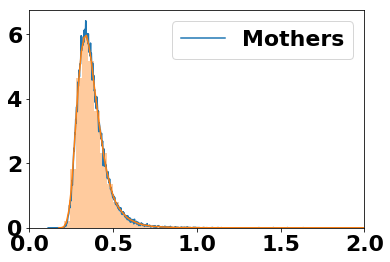

3.58745217323


In [39]:
t1m,t1std=np.mean(t1),np.std(t1)
xv1=np.concatenate((np.linspace(np.amax([0.0,t1m-3*t1std]),t1m+10*t1std, 5001), np.array(t1m+10*t1std*np.exp(np.linspace(np.log(5)/1000,np.log(5),1000)))),axis=0)
# bw = 0.001
L=np.linspace(0.97,1.0,61)
tic=time.time()
plt.plot(xv1,np.exp(kde1.score_samples(xv1[:,None])),label='Mothers')
sns.distplot(t1)
# plt.plot(xv1,np.exp(kde2.score_samples(xv1[:,None])),label='Daughters')
plt.legend()
plt.xlim(left=0.0,right=2.0)
plt.show()
print time.time()-tic

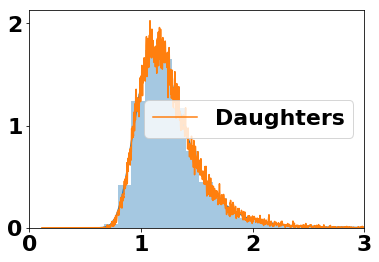

3.94308996201


In [40]:
t1m,t1std=np.mean(t1),np.std(t1)
xv1=np.concatenate((np.linspace(np.amax([0.0,t1m-3*t1std]),t1m+10*t1std, 5001), np.array(t1m+10*t1std*np.exp(np.linspace(np.log(5)/1000,np.log(5),1000)))),axis=0)
bw = 0.001
L=np.linspace(0.97,1.0,61)
tic=time.time()
# plt.plot(xv1,np.exp(kde1.score_samples(xv1[:,None])),label='Mothers')
sns.distplot(t2)
plt.plot(xv1,np.exp(kde2.score_samples(xv1[:,None])),label='Daughters')
plt.legend()
plt.xlim(left=0.0,right=3.0)
plt.show()
print time.time()-tic

In [31]:
bw=0.01
kde1= KernelDensity(bandwidth=bw,kernel='gaussian')
kde2= KernelDensity(bandwidth=bw,kernel='gaussian')
t1=np.array([obj.t_grow for obj in c if obj.celltype==0 and obj.tb>400* params['dt'] * np.log(2)/params['lambda']]).reshape(-1,1)
t2=np.array([obj.t_grow for obj in c if obj.celltype==1 and obj.tb>400* params['dt'] * np.log(2)/params['lambda']]).reshape(-1,1)
kde1.fit(t1)
kde2.fit(t2)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.01, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [34]:
y1=np.zeros(len(L))
y2=np.zeros(len(L))
t1m,t1std=np.mean(t1),np.std(t1)
xv1=np.concatenate((np.linspace(np.amax([0.0,t1m-3*t1std]),t1m+10*t1std, 5001), np.array(t1m+10*t1std*np.exp(np.linspace(np.log(5)/1000,np.log(5),1000)))),axis=0)
t2m,t2std=np.mean(t2),np.std(t2)
xv2=np.concatenate((np.linspace(np.amax([0.0,t2m-3*t2std]),t2m+10*t2std, 5001), np.array(t2m+10*t2std*np.exp(np.linspace(np.log(5)/1000,np.log(5),1000)))),axis=0)
for temp in range(len(L)):
    y1[temp]=integrate.simps(np.exp(kde1.score_samples(xv1[:,None]))*np.exp(-L[temp]*xv1),xv1)
    y2[temp]=integrate.simps(np.exp(kde2.score_samples(xv2[:,None]))*np.exp(-L[temp]*xv2),xv2)
    if np.mod(temp,10)==0:
        print 'Done L:', temp
output_val[inds[0],inds[1],inds[2],1]=L[np.argmin(np.absolute(y1/(1-y2)-1))] # calculating the value of L that fits

Done L: 0
Done L: 10
Done L: 20
Done L: 30
Done L: 40
Done L: 50
Done L: 60


In [35]:
output_val

array([[[[0.97272012, 0.97      ]]]])

In [36]:
np.absolute(y1/(1-y2)-1)

array([0.00954797, 0.01015693, 0.01076525, 0.01137296, 0.01198005,
       0.01258652, 0.01319237, 0.0137976 , 0.01440222, 0.01500622,
       0.01560961, 0.01621238, 0.01681454, 0.01741608, 0.01801702,
       0.01861735, 0.01921707, 0.01981618, 0.02041468, 0.02101257,
       0.02160986, 0.02220655, 0.02280263, 0.02339811, 0.02399299,
       0.02458727, 0.02518095, 0.02577403, 0.02636651, 0.02695839,
       0.02754968, 0.02814037, 0.02873047, 0.02931997, 0.02990889,
       0.03049721, 0.03108494, 0.03167208, 0.03225863, 0.03284459,
       0.03342996, 0.03401475, 0.03459895, 0.03518257, 0.03576561,
       0.03634806, 0.03692993, 0.03751122, 0.03809192, 0.03867205,
       0.0392516 , 0.03983058, 0.04040897, 0.04098679, 0.04156404,
       0.04214071, 0.0427168 , 0.04329233, 0.04386728, 0.04444166,
       0.04501548])